In [1]:
import os, sys
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import cv2

In [2]:
sys.path.append('..')

In [3]:
from src.capture import LazyCapture
from src.cleaning import select_channel, remove_outside_petri
from src.labels import load_labels

In [4]:
def random_load(path): # 'path' can be either a '.avi' or a wildcard for '.jpeg' images
    length, W, H, C = None, None, None, None
    cap = cv2.VideoCapture(path)
    ret, _ = cap.read()
    if not ret:
        cap.release()
        raise Exception("Couldn't read video file: " + path)
    else:
        length, W, H, C = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), 3
    cap.release()
    perm = list(np.random.permutation(np.arange(length)))
    def frames(reverse=False):
        def _ahead():
            cap = cv2.VideoCapture(path)
            for i in perm:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                _, frame = cap.read()
                yield i, frame
            cap.release()
        def _reverse():
            cap = cv2.VideoCapture(path)
            for i in reversed(perm):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                _, frame = cap.read()
                yield i, frame
            cap.release()
        return _reverse() if reverse else _ahead()
    return LazyCapture(length, W, H, C, frames)

In [5]:
cap = random_load('../data/pw1_A1_0315_part3.avi')
labels = load_labels('../data/pw1_A1_0315_part3.txt')

In [6]:
cap.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels.items()}

In [7]:
print("Info: ", cap.length(), cap.W(), cap.H(), cap.C())
print("Labels: ", len(labels))

Info:  12754 648 686 1
Labels:  12690


In [8]:
import itertools as it
class FramesDataset(torch.utils.data.IterableDataset):
    def __init__(self, capture, labels):
        self.capture = capture
        self.labels = dict(list(labels.items())[1:])

    def __iter__(self):
        def frames():
            for i, frame in self.capture.frames():
                if i in self.labels:
                    frame = torch.from_numpy(np.transpose(frame, axes=(2, 0, 1)))
                    label = torch.Tensor(self.labels[i])
                    yield frame, label
        return iter(frames())

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INIT_LR = 1e-4
BATCH_SIZE = 1
EPOCHS = 1

In [10]:
loader = torch.utils.data.DataLoader(FramesDataset(cap, labels), batch_size=BATCH_SIZE)

In [11]:
class Custom_model(torch.nn.Module):
    # Models in PyTorch usually inherit from this Module
    def __init__(self, numChannels):
        super(Custom_model, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=numChannels, out_channels=3, kernel_size=(7, 6))
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(7, 6))
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(7, 6))
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv4 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(7, 6))
        self.relu4 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.fc1 = torch.nn.Linear(300, 600)
        self.fc2 = torch.nn.Linear(600, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.fc1(x.flatten())
        x = self.fc2(x)
        return x

In [12]:
model = Custom_model(numChannels=1).cuda()

In [13]:
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
crit = torch.nn.MSELoss()

In [14]:
full_loss_history = []
loss_history = []
for epoch in range(1, EPOCHS + 1):
    model.train() 

    loss_history = []
    batch_idx = 1
    for data, label in loader:
        data, label = data.to(device), label.to(device)

        pred = model(data)
        loss = crit(pred, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(loss.item())

        if batch_idx % 1000 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item():0.2e}"
            )
        batch_idx = batch_idx + 1

    full_loss_history.extend(loss_history)

/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 1-1000 batch_loss=3.69e-03
Train Epoch: 1-2000 batch_loss=5.69e-03
Train Epoch: 1-3000 batch_loss=1.43e-02
Train Epoch: 1-4000 batch_loss=6.67e-03
Train Epoch: 1-5000 batch_loss=3.09e-04
Train Epoch: 1-6000 batch_loss=6.91e-05
Train Epoch: 1-7000 batch_loss=2.49e-04
Train Epoch: 1-8000 batch_loss=1.42e-03
Train Epoch: 1-9000 batch_loss=1.24e-03
Train Epoch: 1-10000 batch_loss=4.34e-05
Train Epoch: 1-11000 batch_loss=7.60e-03
Train Epoch: 1-12000 batch_loss=5.43e-04


Text(0, 0.5, 'Loss')

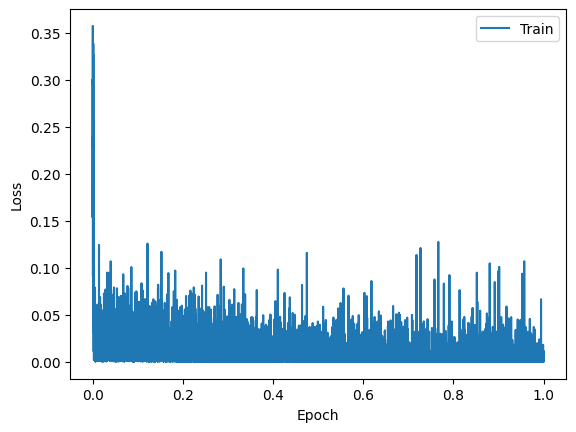

In [15]:
# ===== Plot training curves =====
n_train = len(full_loss_history)
t_train = EPOCHS * np.arange(n_train) / n_train
t_val = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(t_train, full_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Eval

In [16]:
from src.debug import print_frame

In [17]:
cap_e = LazyCapture.load('../data/pw1_A1_0315_part2.avi')
labels_e = load_labels('../data/pw1_A1_0315_part2.txt')

cap_e.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap_e.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels_e = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels_e.items()}

In [18]:
loader_e = torch.utils.data.DataLoader(FramesDataset(cap_e, labels_e), batch_size=1)

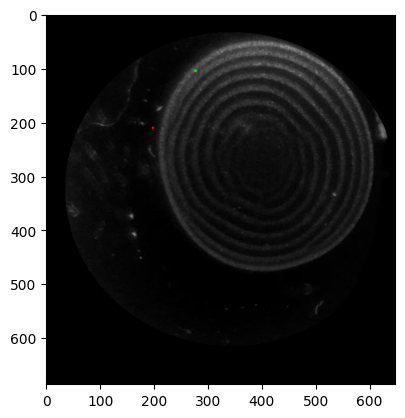

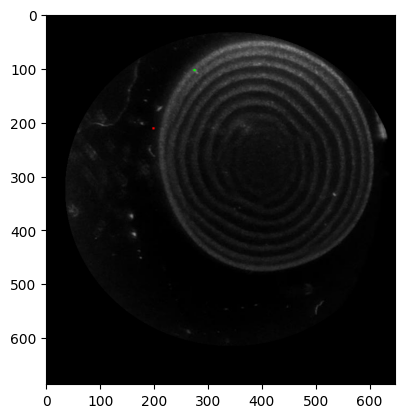

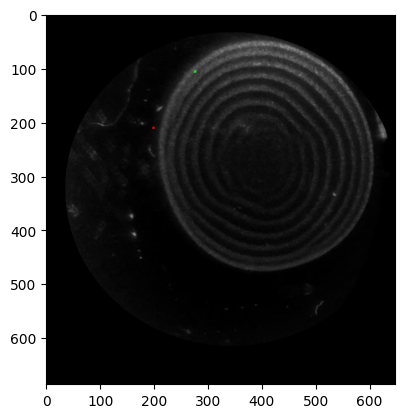

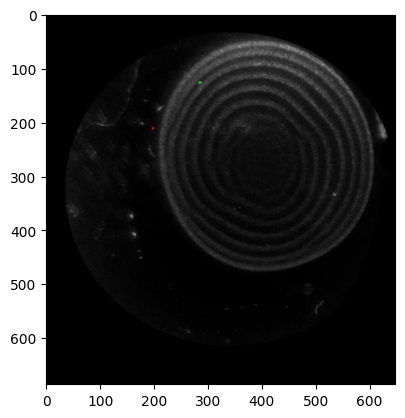

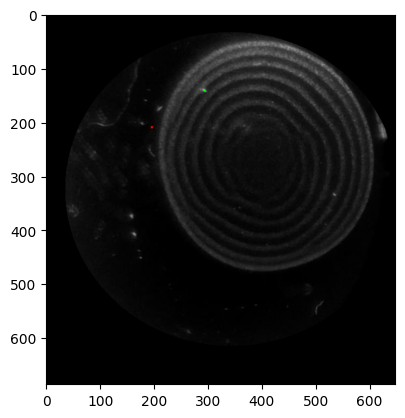

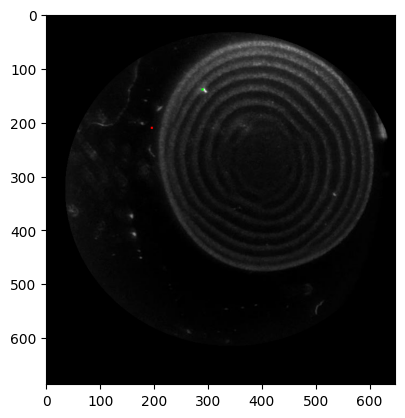

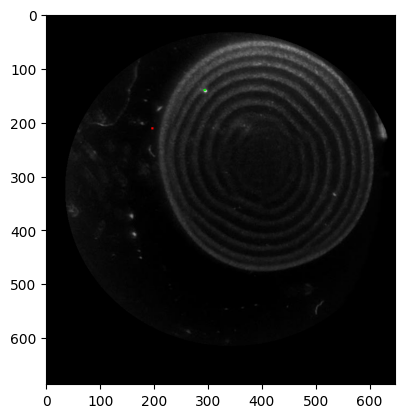

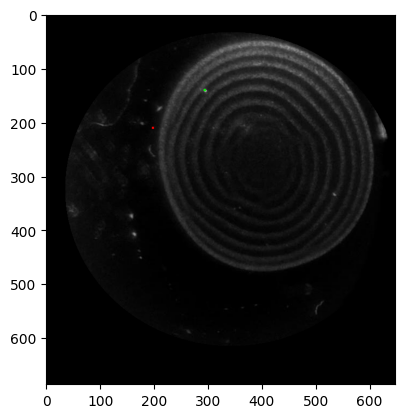

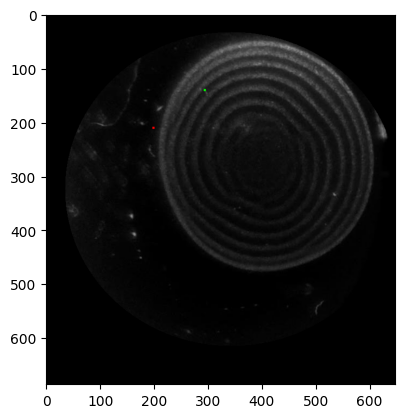

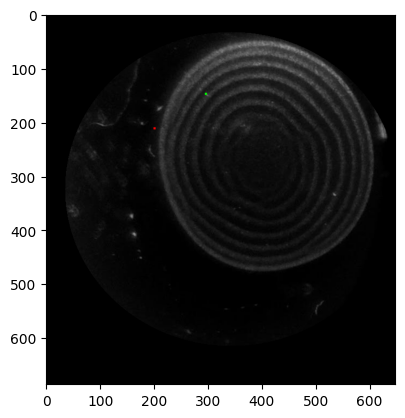

In [19]:
with torch.no_grad():
    for data, label in it.islice(loader_e, 10):
        data, label = data.to(device), label.to(device)
        pred = model(data)

        frame = np.transpose((data[0].cpu().numpy() * 255.0).astype(np.uint8), axes=(1, 2, 0))
        true_pos = (label[0].cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        pred_pos = (pred.cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        print_frame(True)(0, frame, (true_pos, pred_pos))
        